In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights="imagenet",  # モデル初期化のための重みのチェックポイントを指定
                  include_top=False,  # 全結合分類器を含めるかどうか
                  input_shape=(150, 150, 3))

Using TensorFlow backend.
W0709 19:40:25.361932 140735674078080 deprecation_wrapper.py:119] From /Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 19:40:25.372113 140735674078080 deprecation_wrapper.py:119] From /Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 19:40:25.374701 140735674078080 deprecation_wrapper.py:119] From /Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 19:40:25.437303 140735674078080 deprecation_wrapper.py:119] From /Users/mohira/src/github.com/mohira/ml-materials/.venv/

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
import os

import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale=1.0/255)

batch_size = 20


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode="binary")

    i = 0

    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)

        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch

        i += 1

        if i * batch_size >= sample_count:
            break

    return features, labels


train_features, train_labels = extract_features(train_dir,  2000)
validation_features, validation_labels = extract_features(
    validation_dir,  1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [5]:
from keras import layers, models, optimizers

model = models.Sequential()

model.add(layers.Dense(256, activation="relu", input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss="binary_crossentropy",
              metrics=["acc"])

history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features,
                                     validation_labels))

W0709 19:44:05.930703 140735674078080 deprecation.py:506] From /Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0709 19:44:05.970257 140735674078080 deprecation_wrapper.py:119] From /Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 19:44:05.980332 140735674078080 deprecation.py:323] From /Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a fut

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 681us/step - loss: 0.6205 - acc: 0.6500 - val_loss: 0.4520 - val_acc: 0.8380
Epoch 2/30
2000/2000 [==============================] - 1s 546us/step - loss: 0.4397 - acc: 0.7960 - val_loss: 0.3705 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 1s 528us/step - loss: 0.3642 - acc: 0.8425 - val_loss: 0.3304 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 1s 501us/step - loss: 0.3260 - acc: 0.8620 - val_loss: 0.3105 - val_acc: 0.8780
Epoch 5/30
2000/2000 [==============================] - 1s 528us/step - loss: 0.2946 - acc: 0.8800 - val_loss: 0.2899 - val_acc: 0.8850
Epoch 6/30
2000/2000 [==============================] - 1s 495us/step - loss: 0.2710 - acc: 0.8890 - val_loss: 0.2820 - val_acc: 0.8880
Epoch 7/30
2000/2000 [==============================] - 1s 509us/step - loss: 0.2552 - acc: 0.9060 - val_loss: 0.2722 - val_acc: 0.8900


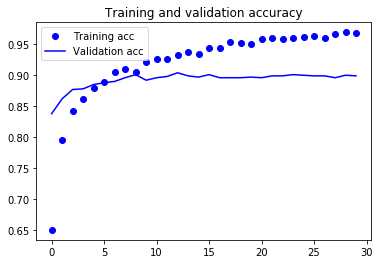

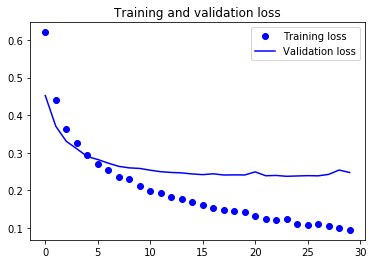

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## まとめ
- ゼロから訓練するより正解率がかなりいい！
- しかし、ドロップアウト結構いれたのに、過学習おきているやん
    - これは、データ拡張をやっていなかったから(小さいデータセットは過学習しやすい)
    

## ファインチューニングの手順
### 訓練済のベースネットワークの最後にカスタムネットワークを追加する
### ベースネットワークを凍結する
### 追加したカスタムネットワークの訓練をおこなう
### ベースネットワークの一部の層を解凍する
### 解凍した層と追加した部分の訓練を同時に行う

In [7]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [8]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(150, 150),
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),  # 学習率はかなり小さく！
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10


ValueError: Error when checking input: expected dense_1_input to have 2 dimensions, but got array with shape (20, 150, 150, 3)